## Construct SEIR model

## Setup notebook

If you need to install these libraries, uncomment and run this cell:

In [1]:
#!pip install numpy
#!pip install matplotlib
#!pip install pandas
#!pip install scipy

Import the necessary modules:

In [2]:
%matplotlib inline
from datetime import datetime
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
from matplotlib.dates import date2num, num2date
from scipy import integrate, optimize
import warnings

warnings.filterwarnings("ignore")

## Setup data

In [3]:
# Cook County population in 2020 is 5,180,493
# New York Times data
url = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"
df = pd.read_csv(url, parse_dates=["date"], dtype={"fips": str})
df = df[(df.fips == "17031") & (df.cases != 0) & (df.date >= "2020-03-01")]

## Construct SEIR model

In [4]:
def base_seir_model(init_vals, params, t):
    """SEIR model implementation.
    
    Takes lists of start values, parameters, and times and runs
    through the SEIR functions.
    
    Args:
        init_vals: Population distribution at start point in each of the four status
        params: change rate between status. beta: S --> E, epsilon: E --> I, gamma: I --> R
        t: progression timeline
    
    Returns:
        Population distribution at the end of the progression.
    """
    S_0, E_0, I_0, R_0 = init_vals
    S, E, I, R = [S_0], [E_0], [I_0], [R_0]
    epsilon, beta, gamma = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        next_S = S[-1] - (beta * S[-1] * I[-1]) * dt
        next_E = E[-1] + (beta * S[-1] * I[-1] - epsilon * E[-1]) * dt
        next_I = I[-1] + (epsilon * E[-1] - gamma * I[-1]) * dt
        next_R = R[-1] + (gamma * I[-1]) * dt
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
    return np.stack([S, E, I, R]).T

## Parameter Optimization

We optimized parameters using reported cases and reported deaths in cook county.

In [5]:
class OptimizeParameters(object):
    """Handles the optimization of parameters for the SEIR model"""
    def __init__(self, init_vals, cases):
        """Initialize the parameter optimization class.
        
        Args:
            init_vals: Population distribution at start point.
            cases: Reported cases in Cook County.
            deaths: Describe.
        """
        self.init_vals = init_vals
        self.cases = cases

    def evaluate(self, params):
        """Describe what's happening here.
        
        Args:
            params: Define.
        
        Returns:
            Describe what is returned.
        """
        S_0, E_0, I_0, R_0 = self.init_vals
        S, E, I, R = [S_0], [E_0], [I_0], [R_0]
        epsilon, beta, gamma = params
        dt = 1
        for _ in range(len(self.cases) - 1):
            next_S = S[-1] - (beta * S[-1] * I[-1]) * dt
            next_E = E[-1] + (beta * S[-1] * I[-1] - epsilon * E[-1]) * dt
            next_I = I[-1] + (epsilon * E[-1] - gamma * I[-1]) * dt
            next_R = R[-1] + (gamma * I[-1]) * dt
            S.append(next_S)
            E.append(next_E)
            I.append(next_I)
            R.append(next_R)
        return E, I

    def error(self, params):
        """Describe what's happening here.
        
        Args:
            params: Define.
        
        Returns:
            Describe what is returned.
        """
        yEim, yIim = self.evaluate(params)
        yCim = [sum(i) for i in zip(yEim, yIim)]  
        res = sum(
            np.subtract(yCim, self.cases) ** 2
        )
        return res

    def optimize(self, params):
        """Describe what's happening here.
        
        Args:
            params: Define.
        
        Returns:
            Describe what is returned.
        """
        res = optimize.minimize(
            self.error,
            params,
            method = "L-BFGS-B",
            bounds = [(0.01, 20.0), (0.01, 20.0), (0.01, 20.0)],
            options = {"xtol": 1e-8, "disp": True, "ftol": 1e-8, "maxiter": 1e7},
        )
        return res

## Run optimization

In [6]:
# Set up population distribution in initial state
N = 5180493
S_0 = (N - 11) / N
E_0 = 10 / N
I_0 = 1 / N
R_0 = 0
init_vals = [S_0, E_0, I_0, R_0]
# Anbitody test preliminary result from LA. The antibody test suggests infected cases is between 221000 and 442000 with margin error. The confirmed cases is 13816.
min_ratio = 221000/13816
max_ratio = 442000/13816

# Parameter reported by researchers
epsilon, beta, gamma = [0.2, 1.75, 0.5]
params = epsilon, beta, gamma

# Instantiate the class
min_seir_eval = OptimizeParameters(init_vals, df.cases / N * min_ratio)
max_seir_eval = OptimizeParameters(init_vals, df.cases / N * max_ratio)

# Run optimiza function
min_opt_p = min_seir_eval.optimize(params)
max_opt_p = max_seir_eval.optimize(params)

## Run simulation using optimized parameters

In [7]:
# define time interval
t_max = 200
dt = 1
t = np.linspace(0, t_max, int(t_max / dt) + 1)
days = len(df.cases) + 14

min_results = base_seir_model(init_vals, min_opt_p.x, t)
max_results = base_seir_model(init_vals, max_opt_p.x, t)

min_simulated_cases = (min_results[:days,1] + min_results[:days,2]) * N/min_ratio
min_simulated_cases = [int(x) for x in min_simulated_cases]

max_simulated_cases = (max_results[:days,1] + max_results[:days,2]) * N/max_ratio
max_simulated_cases = [int(x) for x in max_simulated_cases]

avg_simulated_cases = [sum(i)/2 for i in zip(min_simulated_cases, max_simulated_cases)] 


observed_cases = df.cases

times = [date2num(s) for (s) in df.date]
obs_dates = list(map(lambda x: num2date(x) , times)) 
extra_times=np.linspace(times[-1]+1.0,times[-1] + 14.0,14)
times.extend(extra_times)
sim_dates = list(map(lambda x: num2date(x) , times)) 

obs = pd.DataFrame({"observed_cases":observed_cases,"date":obs_dates})
sim = pd.DataFrame({"min_simulated_cases":min_simulated_cases, "max_simulated_cases":max_simulated_cases ,"date":sim_dates})

sim.to_csv("simulated_cases.txt",index=False,sep = '\t')
obs.to_csv("observed_cases.txt",index=False,sep = '\t')

## Visualize simulated cases vs reported cases

In [8]:
def format_date(x, pos=None):
    """Helper funtion to format dates.
    
    Args:
        x: number of days since 0001-01-01 00:00:00 UTC, plus one.
    
    Kwargs:
        pos: time zone
    
    Returns:
        Dates are returned
    """
    thisind = np.clip(int(startInd + x + 0.5), startInd, startInd + numTimes - 1)
    return num2date(times[thisind]).strftime("%m/%d/%Y")


def validate_modeled(simulated_cases, cases):
    """Validates the SEIR model.
    
    Put more description of what's happening here.
    
    Args:
        simulated_infection: Describe
        infection: Describe
    
    Returns:
        Describe what is returned.
    """
    global times, numTimes
    startInd = 0
    times = [date2num(s) for (s) in df.date]
    times.extend(np.linspace(times[-1]+1.0,times[-1] + 14.0,14))
    
    numTimes = len(simulated_cases)

    fig = plt.figure(figsize=[22, 12], dpi=120)
    fig.subplots_adjust(top=0.85, right=0.92)
    ind1 = np.arange(numTimes)
    ind2 = np.arange(numTimes-14)
    indObs = np.arange(len(simulated_cases))

    ax = fig.add_subplot(111)
    ax.yaxis.grid(True, color="black", linestyle="dashed")
    ax.xaxis.grid(True, color="black", linestyle="dashed")
    ax.set_axisbelow(True)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
    fig.autofmt_xdate()

    (infectedp,) = ax.plot(indObs, simulated_cases, linewidth=3, color="black")
    (si,) = ax.plot(ind1, simulated_cases, linewidth=3, color="orange")
    (i,) = ax.plot(ind2, cases, linewidth=3, color="blue")
    ax.set_xlim(0, numTimes)
    ax.set_xlabel("Date")
    ax.set_ylabel("Case Count")

    plt.legend(
        [si,i],
        ["Simulated Cases","Observed Cases"],
        loc="upper right",
        bbox_to_anchor=(1, 1.22),
        fancybox=True,
    )

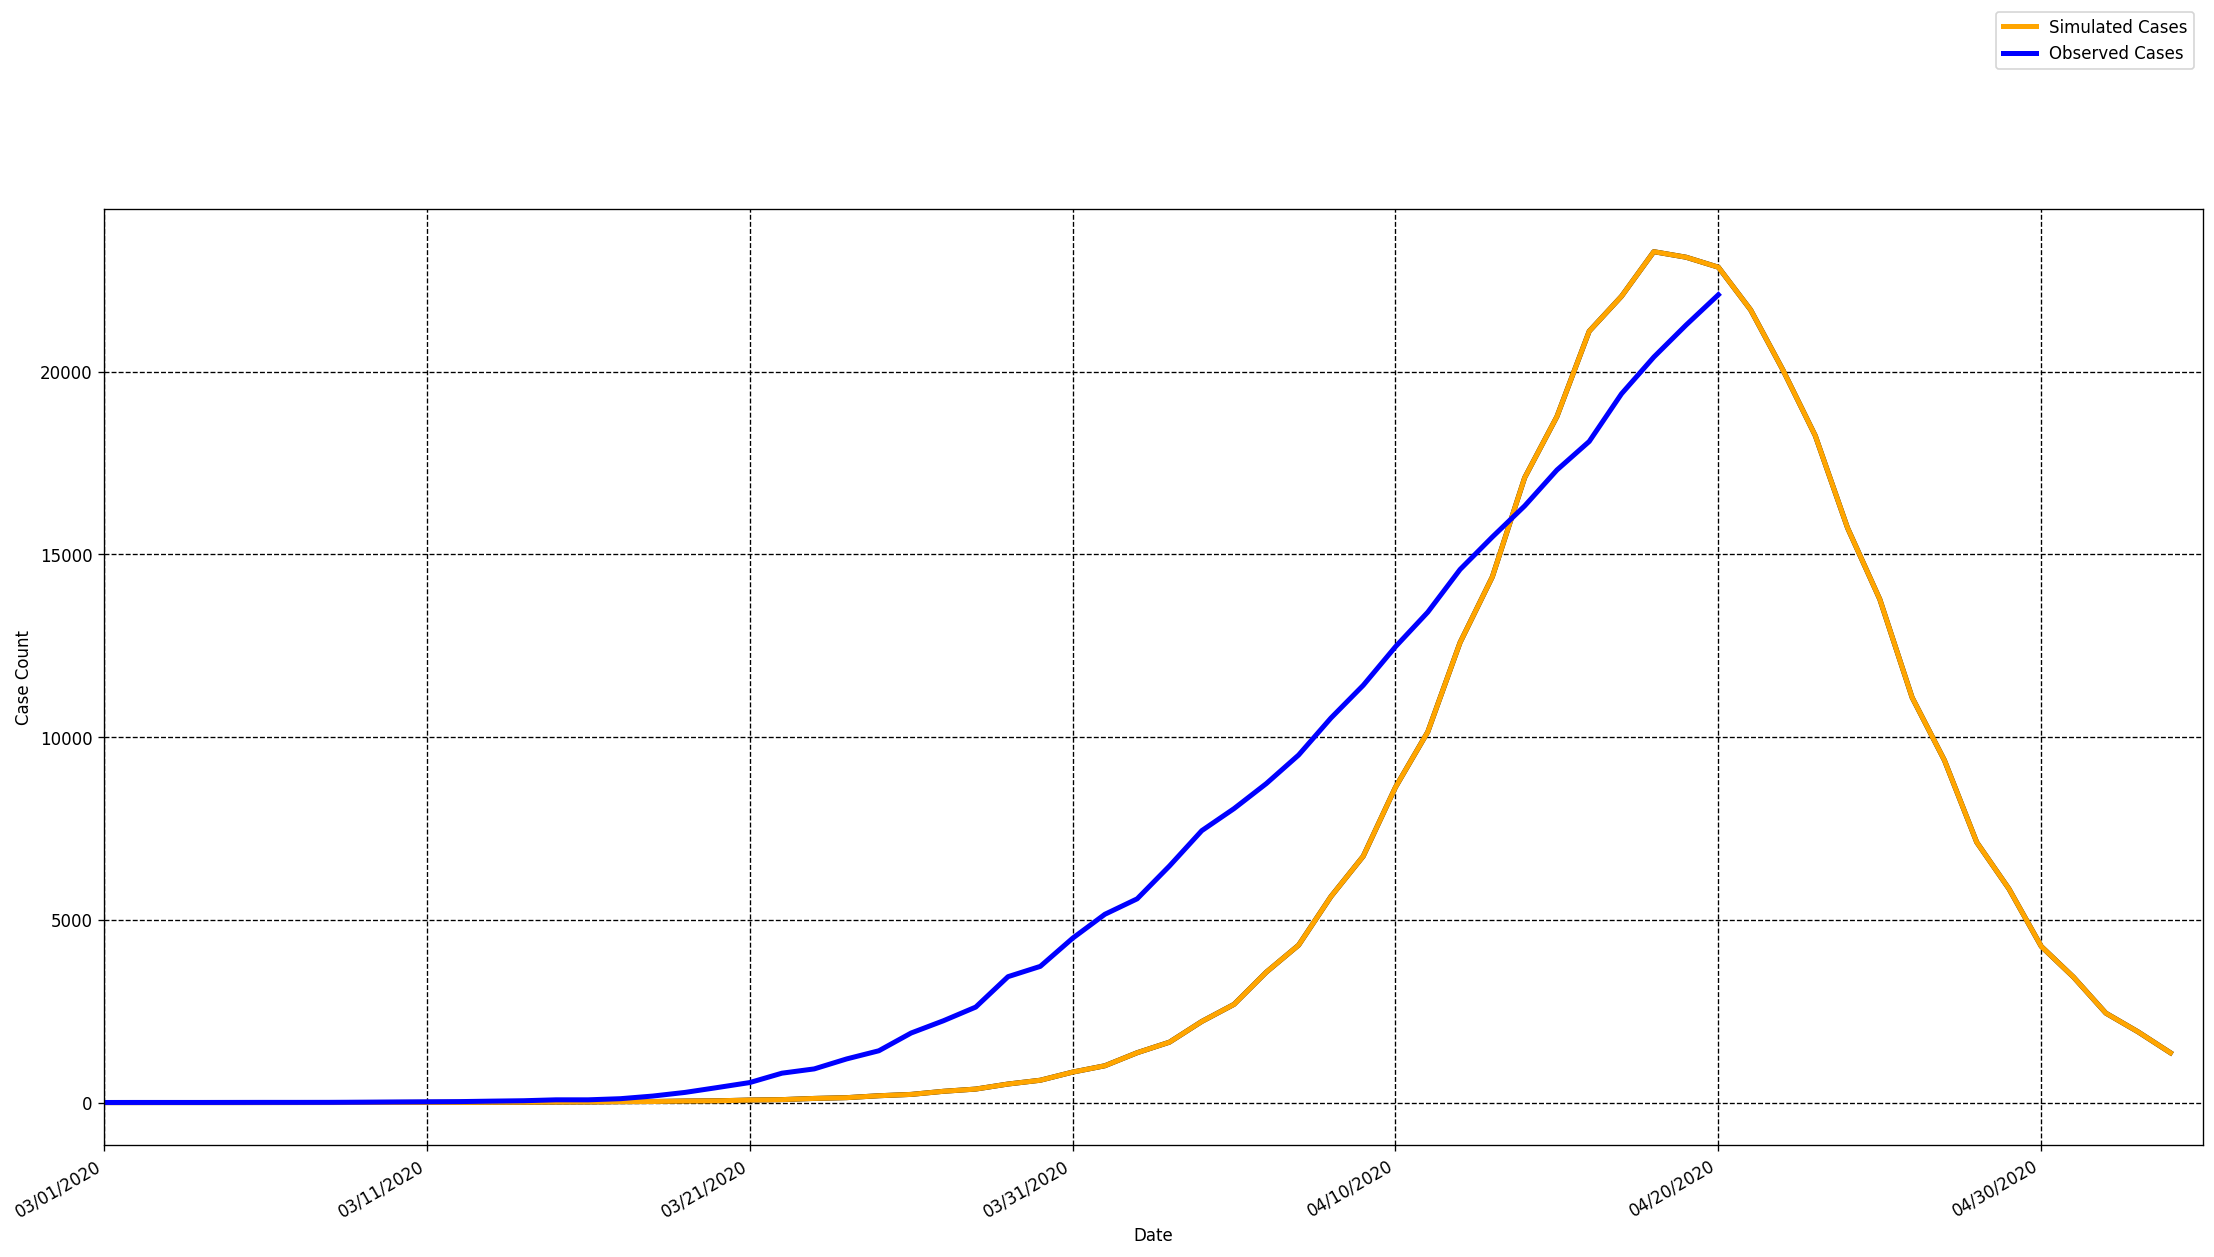

In [9]:
startInd = 0
validate_modeled(avg_simulated_cases, observed_cases)